# Slither Link (数回)

Slither Link (also known as Fences and Loop the Loop) is a logic puzzle with simple rules and challenging solutions.

The rules are simple. 

1. Draw a single closed loop along the grid lines that does not visit any grid point more than once.
2. A number in a cell indicates how many of the four grid lines surrounding that cell are used by the loop.
3. For a cell without a number the loop can use any number of surrounding grid lines.

----------

游戏规则很简单。 

1. 游戏目标是画线连接棋盘上的点形成一条唯一的回路，每个节点被访问不超过1次。
2. 围成每个格子的4条边中，被连接成回路的边的数量必须等于格中数字。
3. 对于没有数字的单元格，回路可以使用任意数量的周围网格线。



- [Puzzle Wiki](https://www.puzzles.wiki/wiki/Slitherlink);

- [Janko's Site](https://www.janko.at/Raetsel/Slitherlink/index.htm);

> Puzzles and Games: A Mathematical Modeling Approach. Tony Hürlimann, 2015 




-----

## 棋盘表示

以 `assets/data/Slitherlink/problems/122_10x18.txt` 文件为例，表示棋盘：

![](https://cdn.jsdelivr.net/gh/SmilingWayne/picsrepo/202409280914553.png)

第一行是两个数字 $m, n$，以空格分开，分别表示棋盘的行数和列数。

后面紧接着 m 行，每一行有 n 个符号，用空格分开，表示该行每个该行该列中网格里的数字。注意，数字仅能取 $0，1，2，3$，如果网格中没有数字，则取 "-" 。

> 注意：problems文件夹外的一些数据文档，网格中无数字时的符号为 "."。该问题会在后续统一。


```txt
10 18
0 - - 3 - 3 - 1 1 - 3 - - - - 3 - 1
- - - - 2 - 3 - - 0 - 1 - 3 3 - 3 -
3 - 3 2 - - - 1 - 2 - - 1 - - - - 1
- 1 - - 2 - 0 - 2 - - - - 0 - - 1 -
0 - - - - 3 - - 3 - 3 3 - - 1 3 - -
- - 1 0 - - 1 3 - 1 - - 2 - - - - 1
- 3 - - 3 - - - - 1 - 2 - 1 - - 3 -
1 - - - - 2 - - 0 - 3 - - - 3 2 - 0
- 1 - 0 3 - 3 - 1 - - 3 - 2 - - - -
3 - 3 - - - - 1 - 2 0 - 0 - 3 - - 3
```

----

## 问题建模

对于一个 $m \times n$ 的网格，我们现在专注于每一个格子的四条边。每一个格子都有4个**顶点**，这些顶点之间的互相连接，构成了棋盘的最终解。网格会和相邻网格的顶点重合。以上述表格第一行为例，

`0 - - 3 - 3 - 1 1 - 3 - - - - 3 - 1`

我们按照从上到下，从左到右对18个格子的顶点从0开始进行编号。第一行18个格子的上顶点有19个，下顶点也有19个，其中有一些是共享节点。如图示。

![](https://cdn.jsdelivr.net/gh/SmilingWayne/picsrepo/202409280940808.png)

我们可以发现，对于一个$m \times n$ 的网格，有 $(m + 1) \times (n + 1)$ 个非重复的顶点。记顶点集合为 $V$。由于每个顶点至多和4个其他顶点相连（有一些顶点仅和两个顶点相连），整个网格共有 $2 mn + m + n$ 条边。记边的集合为 $E$.

我们的任务实际就是选择这些边中的一些边连接起来，满足方格中数字约束与环路约束。




我们用两个节点编号来描述“边”，比如，(0,1) 表示0-1的边，以此类推。上图中，(3, 4), (3, 22), (4, 23), (20,21)， (21, 22) 等边是被连接的，其他的没有连接。

我们用 0-1 决策变量 $x_{ij}$ 表示边 $(i, j)$ 是否被连接。记原始的 $m \times n$ 棋盘为 $G$, $G_{a,b}$ 表示原来棋盘第 $a$ 行第 $b$ 列的数字，$S_{a,b}$ 表示棋盘第 $a$ 行第 $b$ 列方格周围的边的集合。

所以我们可以把方格数字约束写成：

$$\sum_{(i, j) \in S_{a,b}} x_{ij} = G_{a,b}, \quad a = 1, 2, \cdots, m; b = 1, 2, \cdots, n$$

仿照路径规划的流平衡，对于每个顶点流入流出是相等的；同时每一个顶点至多流出一条边。所以可以写成：

$$\sum_{j \in V} x_{ij} = \sum_{j \in V} x_{ji} \leq 1, \quad i \in V$$

这里因为我们用 $(i, j)$ 对边进行表示，在终盘里 $(i, j)$ 和 $(j, i)$ 实际上是同一个边，所以可以加一个约束，限制这两条边至多只能选一个。

$$x_{ij} + x_{ji} \leq 1, \forall (i, j) \in E \quad \text{and} \quad i \leq j$$

上述两个约束保证了可以生成一些环路，但是不保证整个图都可以连成一个完整的环，而是存在子环(Subtour).比如下图红圈内的情况：

![](https://cdn.jsdelivr.net/gh/SmilingWayne/picsrepo/202409281039368.png)

此时我们每次求解后，动态地添加去子环约束。比如如果我们发现某个解中出现了子环路，也就是说我们发现了一个边集合 $T$，这个集合里的边首尾相连。那么我们只需要仿照旅行商问题中的DFJ formulation，加入如下约束：

$$\sum_{(i, j) \in T} x_{ij} \leq |T| - 1 \quad \forall |T| \geq 2$$

约束的本质是限制围城这个子环路的所有边在终盘里不会全部被选中。即假设这个子环路由 $|T|$ 条边组成，约束这 $| T |$ 个边至多同时被选中 $|T| - 1$ 个。

我们用Gurobi求解上述模型，即可得到最终盘。每一个整数规划求解器都可以用来编程求解。上述终盘也就是:


![](https://cdn.jsdelivr.net/gh/SmilingWayne/picsrepo/202409281047352.png)

----------

## 一些有意思的试验

现在有很多很多的棋盘，我能找到的最大的是 $60 \times 60$ 的谜题，来自[这个SudokuFans链接](http://www.sudokufans.org.cn/main.index.php?type=loop60)（需要注册）。虽然没法直接从网页端解析这个棋盘，最后我是截图切片识别数字，解析了这个棋盘并求解。

Gurobi能在24s内找到终盘。连接了3556条边，总共加入了162条去子环约束。可视化如下。

![](https://cdn.jsdelivr.net/gh/SmilingWayne/picsrepo/202409281058239.png)

除了这种超大规模数据外，Janko网站有非常多非常多的谜题数据，[参考链接。](https://www.janko.at/Raetsel/Slitherlink/index-2.htm)

我目前爬了一部分数据和终盘的答案，大概100+个题目，放在我的[这个Github仓库](https://github.com/SmilingWayne/PuzzleSolver/tree/main/assets/data/slitherlinkdata) 里了，仓库里还有许多别的谜题和数据。

Janko网站里的谜题数据格式比较统一，而且终盘的表示是比较特殊的，因为我们的终盘要求边连成一个唯一回路，所以这个回路一定会把某些格子围起来。Janko网站里每个终盘就是用“某格是否在终盘里被围起来”进行表示的。用 `x` 表示该格子被围起，否则`-`表示没有被围。以上述 $10 \times 18$ 棋盘为例，终盘的表示为：

```txt
10 18
- - - x - x x x x x - x - - - x - - 
- x x x - - - x x x x x - x - x - x 
x x - x x x x x - x x x x x x x x x 
- - - - - x x x - - x x x x x x x x 
- - - x - - x x x - x - x x x - - x 
- x x x x x x - - - - - - x x x - - 
- - x x - x x x x x x x - x x x x - 
- x x x - - x x x x - x - x - - - - 
- x x x x - x - x x - x - x x x x - 
x x - x - - - - x - - - - - x - x x
```




## HERE is the code.

In [2]:

import networkx as nx
import matplotlib.pyplot as plt
import math
import gurobipy as grb
import numpy as np
import os
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle
import warnings 
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")
from Utils.grid_utils import vertex_to_arcs

# ======== Visualization ===========

def coordinatesParser(m, n, idx):
    """_summary_
        Coordinate Parser for visualization 
    Args:
        m (_type_): _description_
        n (_type_): _description_
        idx (_type_): _description_

    Returns:
        _type_: _description_
    """
    ori_x , ori_y = idx // n, idx % n 
    return (0.5 + ori_y, 0.5 + ( m - ori_x - 1) )

def coordinatesParserNodes(m, n, idx):
    ori_x, ori_y = idx // (n + 1), idx % (n + 1)
    return (ori_y, m - ori_x )


def Vis(m, n, grid, result):
    """_summary_

    Args:
        m (int): Height of the grid
        n (int): Width of the grid
        grid (List[List[int]]): The Grid
        result (Dict["arcs": List[[int, int]]]): The result.
        
        The vertex is defined in [ 0 ~ (m + 1) * (n + 1) ]. As:
        
        0 ______ 1 ______ 2 ______ .... ___ n
        |         |         |              |
        |         |         |              |
       n+1 _____ n+2 _____ n+3 ......___   2*n
        |
        ..
        ..
      m*(n+1)....................      (m+1)*(n+1)
      
        The arc is defined by the vertex index, always from the smaller one to larger one. 
        
        For example:
        
        (0,1), (1,n+2), (0,n+1), ...  etc.
    """
    plt.figure(figsize=(n,m))

    ax = plt.gca()
    x_major_locator = MultipleLocator(1)
    y_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    # set main axis as 1 
    ax.yaxis.set_major_locator(y_major_locator)

    plt.xlim(0,n)
    plt.ylim(0,m)

    plt.grid(linestyle = "--")

    # Draw squares that unvisited
    for i in range(m):
        for j in range(n):
            if grids[i][j] != -1:    
                new_coor = coordinatesParser(m, n, i * n + j)
                ax.text(new_coor[0], new_coor[1], str(grids[i][j]), 
                        horizontalalignment = "center", 
                        verticalalignment = 'center',
                        fontsize = 24)

    # draw result lines
    for line in result["arcs"]:
        dot1 = coordinatesParserNodes(m, n, line[0])
        dot2 = coordinatesParserNodes(m, n, line[1])
        plt.plot([dot1[0], dot2[0]], [dot1[1], dot2[1]], linestyle="-", linewidth = 4, color = "blue") 
    plt.show()

In [3]:
def readInstance(path):
    # file_name = f"../assets/data/slitherlinkdata/{path}{np.random.randint(1)+1}.txt"
    file_name = f"../assets/data/Slitherlink/problems/{path}"

    m = 0
    n = 0
    grids = None
    print( f"READING FILE {file_name}" )
    if not os.path.isfile(file_name):
        print('File does not exist')
    else:
        
        with open(file_name) as file:
            firstline = file.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            grids = [[-1 for _ in range(n)] for _ in range(m)]
            for idx in range(m):
                line = file.readline().strip().split(" ")
                
                for j in range(n):
                    if line[j] not in ['.', '-']:
                        grids[idx][j] = int(line[j])
    return m, n, grids

if __name__ == "__main__":
    # data = "30x25normal1"
    # data = "15x15medium1"
    data = "655_17x17.txt"
    m, n, grids = readInstance(data)
    # print(grids)
    for row in grids:
        print(row)

READING FILE ../assets/data/Slitherlink/problems/655_17x17.txt
[-1, -1, -1, 2, 3, 2, 3, -1, -1, 2, -1, -1, -1, 2, 2, -1, -1]
[-1, -1, 1, -1, -1, -1, 1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[2, -1, 3, 2, 1, 3, -1, 3, -1, -1, 2, -1, 2, 2, 2, 2, -1]
[3, -1, -1, -1, 2, -1, 0, 3, -1, 3, 1, -1, 2, -1, 1, 1, 2]
[-1, -1, -1, -1, -1, -1, -1, -1, 1, 3, -1, -1, -1, 3, 3, 2, -1]
[-1, 1, 3, -1, 3, 1, -1, -1, 3, -1, -1, -1, -1, 1, 2, -1, 2]
[-1, -1, 2, 1, -1, 1, 2, -1, 2, 2, -1, -1, -1, -1, -1, 2, 0]
[3, 2, -1, 2, 2, 2, 2, 3, 2, -1, -1, 1, -1, -1, -1, -1, -1]
[-1, 1, 3, 2, 2, -1, 2, -1, -1, 2, 3, 1, -1, -1, -1, 2, -1]
[-1, 1, -1, -1, -1, -1, 2, 1, -1, 2, -1, 1, 2, -1, -1, -1, -1]
[-1, -1, -1, -1, 2, -1, 3, 2, 2, 2, 3, -1, 2, 2, -1, 0, 2]
[-1, 2, 1, -1, 2, 3, 1, 1, -1, 2, -1, 2, -1, 3, -1, -1, -1]
[-1, -1, 1, 1, -1, 2, 1, 1, 2, 3, -1, -1, -1, -1, 2, 2, 2]
[-1, 3, 3, 3, 2, -1, 2, 3, -1, 2, 1, 3, -1, -1, 3, 2, 2]
[-1, 2, 0, 2, 1, 3, 2, 1, -1, 1, -1, 2, -1, 1, 2, -1, -1]
[-1, -1, 2, 3, 2, 2, -1, 2, -1

In [4]:
from pyscipopt import Model, quicksum
import time
import networkx
    
def cell2Arcs(m, n, i, j):
    upperLeft = (n + 1) * i + j
    return [
        (upperLeft, upperLeft + 1),
        (upperLeft, upperLeft + n + 1),
        (upperLeft + 1, upperLeft + n + 2),
        (upperLeft + n + 1, upperLeft + n + 2)
    ]
    # New Constraints
    
def SlitherlinkWithSCIP(m, n, grids):
    starttime = time.time()
    model = Model("Slitherlink")
    x = {}
    node2Arc = {}
    all_arcs = []
    
    for i in range(m + 1):
        for j in range(n + 1):
            if i != m and j != n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {i * (n + 1) + j + 1}]"
                )
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {(i + 1) * (n + 1) + j}]"
                )
                all_arcs.append((i * (n + 1) + j, i * (n + 1) + j + 1))
                all_arcs.append((i * (n + 1) + j, (i + 1) * (n + 1) + j))
            elif i == m and j != n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {i * (n + 1) + j + 1}]"
                )
                all_arcs.append((i * (n + 1) + j, i * (n + 1) + j + 1))
            elif i != m and j == n:
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {(i + 1) * (n + 1) + j}]"
                )
                all_arcs.append((i * (n + 1) + j, (i + 1) * (n + 1) + j))
            node2Arc[i, j] = vertex_to_arcs(m, n, i, j)
            x[i, j, 0] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i}, {j}, 0]"
                )

    for i in range(m + 1):
        for j in range(n + 1):
            model.addCons(quicksum(x[a, b] for (a, b) in node2Arc[i, j]) == 2 * x[i, j, 0], name = f"Balance_{i}_{j}")
    
    for i in range(m):
        for j in range(n):
            if grids[i][j] >= 0 and grids[i][j] < 4:
                model.addCons(quicksum(x[a, b] for (a, b) in cell2Arcs(m, n, i, j)) == grids[i][j], name = f"#ofnode_{i}_{j}")
                
    # print(grids)
    model.setObjective(quicksum(x[a, b] for (a, b) in all_arcs), "minimize")
    model.hideOutput()
    def addCut(edges):
        G = networkx.Graph()
        G.add_edges_from(edges)
        components = list( list(c) for c in networkx.connected_components(G))
        # print(f"Totally: {len(components)} subtours!")
        if len(components) == 1:
            return False
        else:
            # cutting_edges = []
            for component in components:
                prev = -1
                curr = component[0]
                cntt = len(component)
                nodeSet = set(component)
                temp = list()
                while cntt > 0:
                    for direct in [- n - 1, n + 1, -1, 1]:
                        target = direct + curr 
                        curredge = (curr, target) if curr < target else (target, curr)
                        if target in nodeSet and target != prev and curredge in edges:
                            temp.append(curredge)
                            prev = curr 
                            curr = target 
                            break 
                    cntt -= 1
                model.freeTransform()
                model.addCons(quicksum(x[a, b] for (a, b) in temp) <= len(temp) - 1)
                # print("Add Cut!")
            return True
                
    arcs = []
    while True:
        model.optimize()
        edges = []
        for cur_key in x.keys():
            if len(cur_key) < 3:
                a, b = cur_key[0], cur_key[1]
                if model.getVal( x[a, b]) > 1e-1:
                    edges.append((a, b))
        if not addCut(edges):
            print(f"Model Status: {model.getStatus()}")
            print(f"Total arcs: {model.getObjVal()}")
            sol = model.getBestSol()
            for (a, b) in all_arcs:
                if sol[x[a, b]] > 1e-1:
                    arcs.append([a, b])
            break
    endtime = time.time()
    print(f"Running time: {(round(endtime - starttime, 3)) } seconds")
    return arcs


if __name__ == "__main__":
    # data = "60x60_1"
    # m, n, grids = readInstance(data)
    # result = SlitherlinkWithSCIP(m, n, grids)
    # Vis(m, n, grids, {'arcs': result})
    
    txt_files = []
    datasetRouter = "../assets/data/Slitherlink/problems/"
    for root, dirs, files in os.walk(datasetRouter):
        txt_files.extend([f for f in files if f.endswith('.txt')])
# txt_files[539:]
    for f in ["655_17x17.txt"]:
        try:
            m, n, grids = readInstance(f)
            result = SlitherlinkWithSCIP(m, n, grids)
        except Exception:
            print(f"Wrong! File {f} failed to process!")

# hardcase: 1165_10x10.txt, 709_20x36.txt
# 539 + 108?


READING FILE ../assets/data/Slitherlink/problems/655_17x17.txt
Model Status: optimal
Total arcs: 316.0
Running time: 0.076 seconds


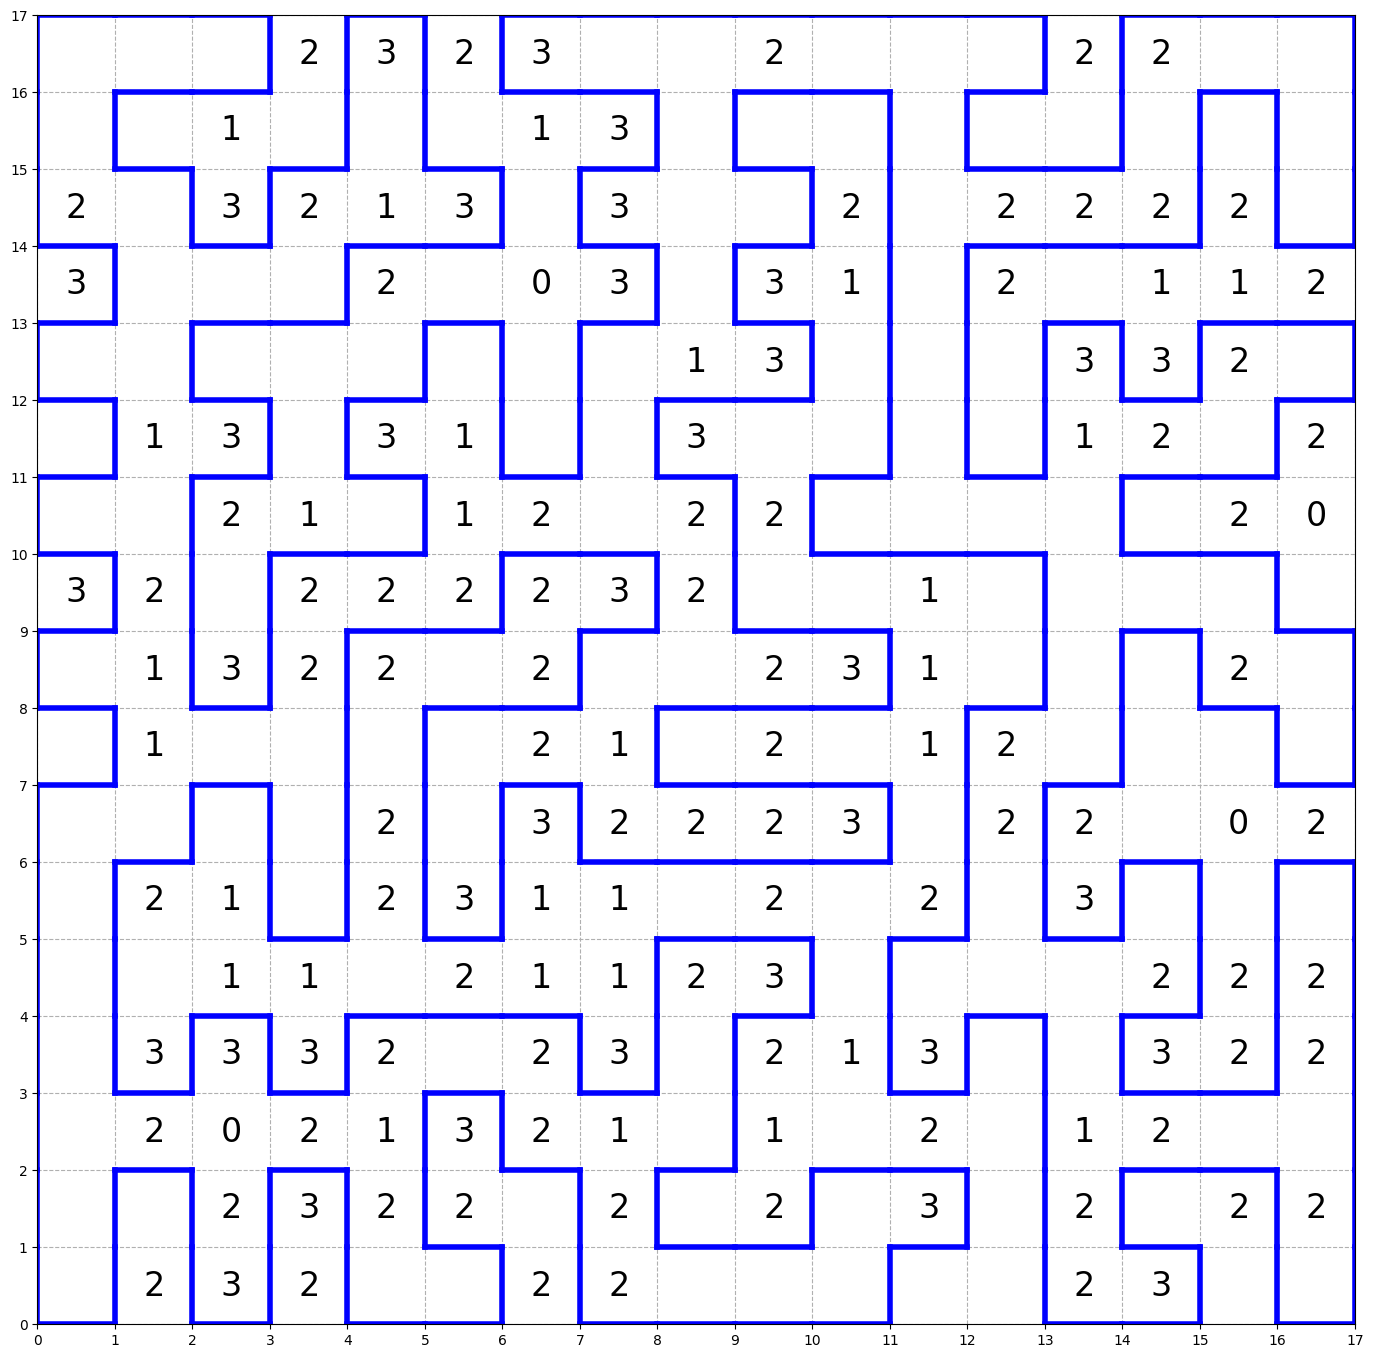

In [5]:


if __name__ == "__main__":

    arcs = {"arcs": result }
    Vis(m, n, grids, arcs)

## Gurobi solver code.

> Note: The formulation is a little bit complicated. For simple and clear formulation, refer to SCIP code above.
>
> The Gurobi code is useful and proved to be correct.

Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-29
All lines (After double) 1224
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 1405 rows, 1224 columns and 6056 nonzeros
Model fingerprint: 0x47b8c35b
Variable types: 0 continuous, 1224 integer (1224 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 399 rows and 252 columns
Presolve time: 0.01s
Presolved: 1006 rows, 972 columns, 4437 nonzeros
Variable types: 0 continuous, 972 integer (972 binary)

Root relaxation: objective 2.240000e+02, 668 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntI

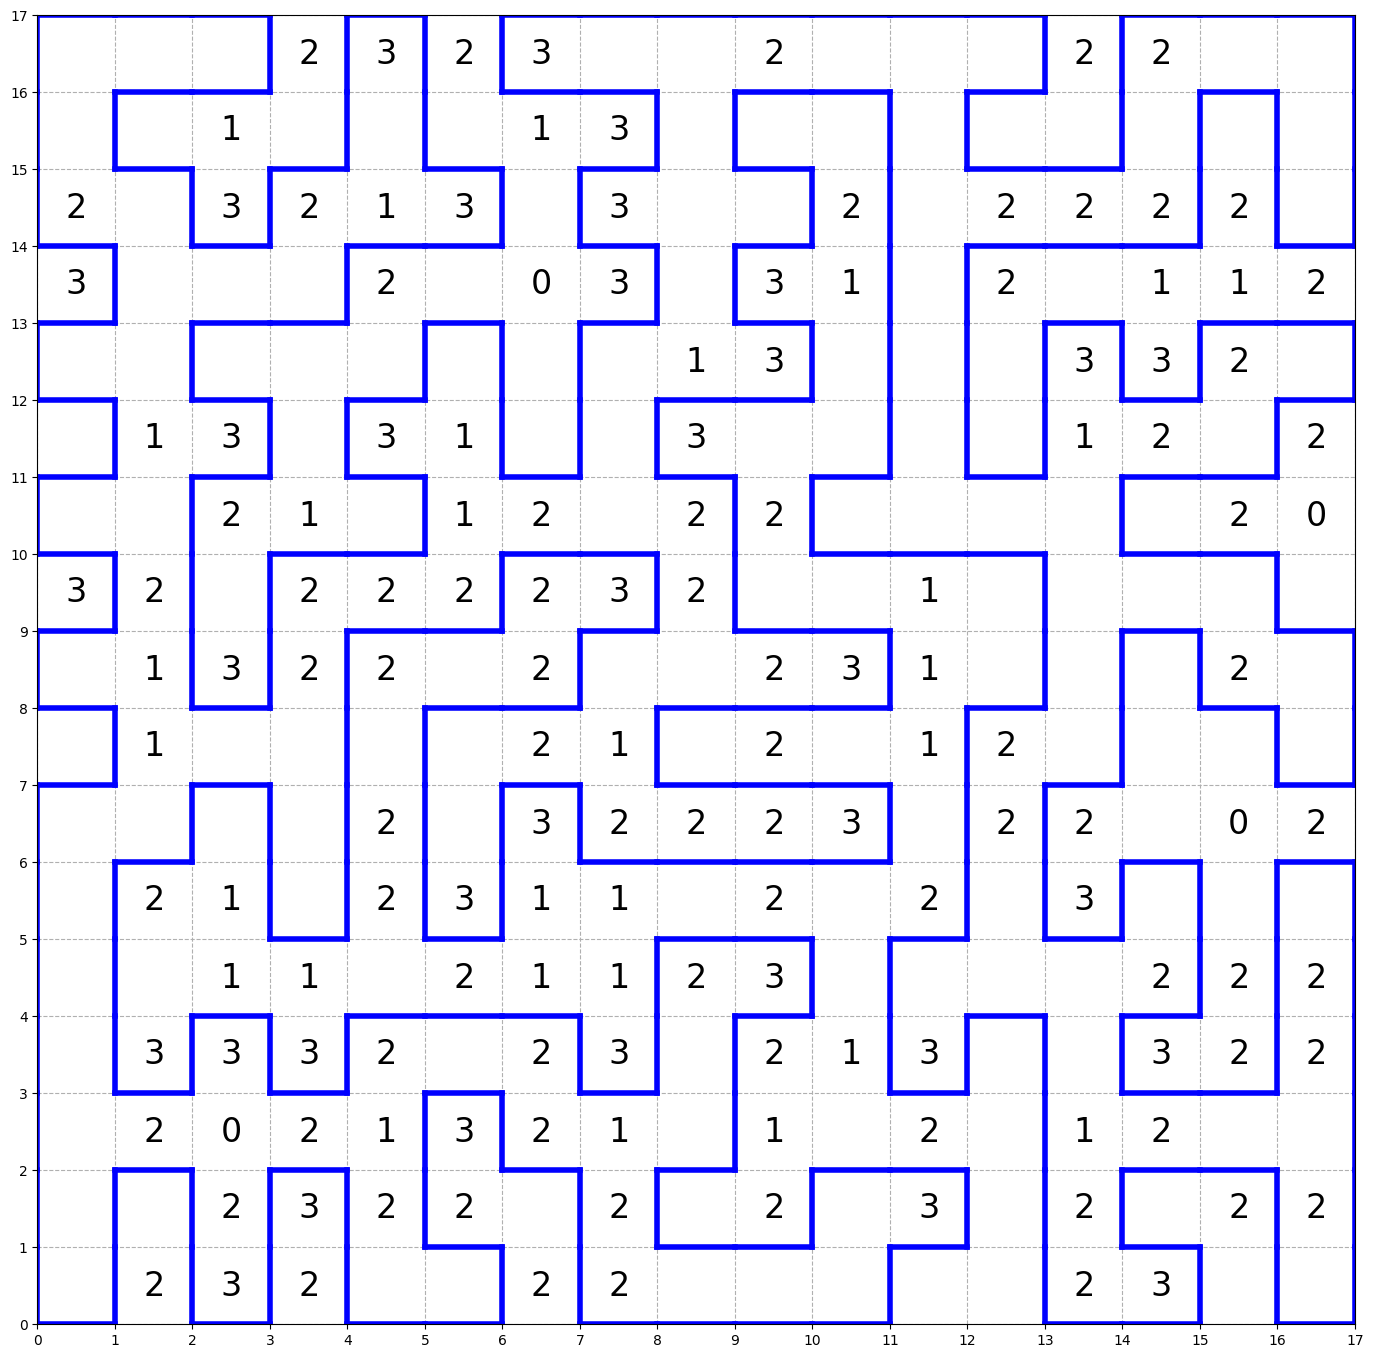

In [6]:
def Node2Corners(m, n, i, j):
    upperLeft = (n + 1) * i + j
    return [
        (upperLeft, upperLeft + 1),
        (upperLeft + 1, upperLeft + n + 2),
        (upperLeft + n + 2, upperLeft + n + 1),
        (upperLeft + n + 1, upperLeft),
        (upperLeft + 1, upperLeft),
        (upperLeft + n + 2, upperLeft + 1),
        (upperLeft + n + 1, upperLeft + n + 2),
        (upperLeft, upperLeft + n + 1)
    ]

def SlitherlinkwithLazyCuts(m, n, grids) :
    """_summary_

    Args:
        m (_type_): 行数
        n (_type_): 列数
    """
    
    Slitherlink = grb.Model("SlitherLink")
    x = {}
    nodes_num = (m + 1) * (n + 1)
    to_dict = {}
    
    # 按照下标对节点进行表示
    # 节点的数量
    for i in range(m + 1):
        for j in range(n + 1):
            to_dict[i * (n + 1) + j] = []
            if j + 1 <= n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = Slitherlink.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1) + j},{i * (n + 1) + j + 1}]"
                )
                x[i * (n + 1) + j + 1, i * (n + 1) + j] = Slitherlink.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1) + j + 1},{i * (n + 1) + j}]"
                )
            if i < m:
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = Slitherlink.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1)},{(i + 1) * (n + 1)}]"
                )
                x[(i + 1) * (n + 1) + j, i * (n + 1) + j] = Slitherlink.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{(i + 1) * (n + 1)}, {i * (n + 1)}]"
                )
            if i > 0:
                to_dict[i * (n + 1) + j].append((i - 1) * (n + 1) + j)
            if i < m:
                to_dict[i * (n + 1) + j].append((i + 1) * (n + 1) + j)
            if j > 0:
                to_dict[i * (n + 1) + j].append(i * (n + 1) + j - 1)
            if j < n:
                to_dict[i * (n + 1) + j].append(i * (n + 1) + j + 1)
    
    print(f"All lines (After double) {len(x)}")
    Slitherlink.modelSense = grb.GRB.MINIMIZE
    Slitherlink.Params.lazyConstraints = 1
    Slitherlink.update()
    
    for i in range(nodes_num):
        # 流平衡约束（由于并不一定要访问所有的节点，所以这里不需要强制为1，相较于TSP要做一个松弛）
        Slitherlink.addConstr(grb.quicksum(x[i, j] for j in to_dict[i]) == grb.quicksum(x[j, i] for j in to_dict[i]), name = f"Balance_Node_{i}")
        Slitherlink.addConstr(grb.quicksum(x[i, j] for j in to_dict[i]) <= 1, name = f"Balance_Node_{i}_not_greater_than1")
        for target in to_dict[i]:
            if target > i:
                Slitherlink.addConstr(x[i, target] + x[target, i] <= 1, name = f"ChooseOne{i}_{target}")
    
    for i in range(len(grids)):
        for j in range(len(grids[0])):
            if grids[i][j] >= 0 and grids[i][j] < 4:
                Slitherlink.addConstr(grb.quicksum(x[xx, yy] for (xx, yy) in Node2Corners(m, n, i, j)) == grids[i][j], name = f"#ofnode_{i}_{j}")
    
    def subtourelim(model, where):
        # 回调函数
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            # 从新的 MIP 解决方案中检索值。
            G = nx.Graph()
            nodes_appear = []
            for (i, j) in x.keys():
                if (x_sol[i, j] > 0.9):
                    if i not in nodes_appear:
                        nodes_appear.append(i)
                    if j not in nodes_appear:
                        nodes_appear.append(j)
                    G.add_edge(i, j, weight = 1)
            components = [list(c) for c in nx.connected_components(G)]
            # 获得当前图里所有的子环路
            print("The length is " + str(len(components)))
            for component in components:
                if (len(component) < len(nodes_appear)):
                    # 消除那些环路
                    print(f"Add cut to eliminate Tour:{component}")
                    model.cbLazy(grb.quicksum(x[i,j] for i in component \
                        for j in component if j in to_dict[i]) <= len(component) - 1)
                    
    Slitherlink._x = x
    Slitherlink.optimize(subtourelim)
    # Slitherlink.optimize()
    # Slitherlink.write("Slitherlink.lp")

    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (Slitherlink.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = Slitherlink.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        gap = 0
        lb = ofv
        ub = ofv
        runtime = Slitherlink.Runtime
    elif (Slitherlink.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = Slitherlink.MIPGap
        lb = Slitherlink.ObjBoundC
        ub = Slitherlink.ObjVal
        runtime = Slitherlink.Runtime

    return {
        "TotalCost": ofv,
        "runtime": runtime,
        "arcs": arcs
    }
    
    
if __name__ == "__main__":
    result = SlitherlinkwithLazyCuts(m, n, grids)
    # print(result)
    Vis(m, n, grids, result)

----

## A demo for subtour detection

In [11]:

def find_subtours(edges):
    def dfs(edge, path, visited):
        if visited[edge]:
            if path and path[0] == edge:
                subtours.add(tuple(sorted(path)))
            return
        visited[edge] = True
        path.append(edge)

        for adjacent in adjacency_list[edge]:
            dfs(adjacent, path, visited)
        
        path.pop()
        visited[edge] = False

    # Create an adjacency list
    adjacency_list = {edge: [] for edge in edges}
    for edge in edges:
        # Assuming 'edges' is a list of tuples (u, v) representing edges
        u, v = edge
        for adjacent_edge in edges:
            if edge != adjacent_edge and (u in adjacent_edge or v in adjacent_edge):
                adjacency_list[edge].append(adjacent_edge)

    visited = {edge: False for edge in edges}
    subtours = set()
    for edge in edges:
        dfs(edge, [], visited)

    return [list(subtour) for subtour in subtours]

# Example usage
edges = [(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 3)]
subtours = find_subtours(edges)
print(subtours)


[[(3, 1), (3, 4), (4, 5), (5, 3)], [(2, 3), (3, 4), (5, 3)], [(2, 3), (5, 3)], [(2, 3), (3, 4), (4, 5), (5, 3)], [(2, 3), (3, 1)], [(1, 2), (2, 3), (3, 1), (3, 4)], [(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 3)], [(4, 5), (5, 3)], [(3, 4), (5, 3)], [(2, 3), (3, 1), (3, 4)], [(3, 1), (3, 4)], [(1, 2), (2, 3), (3, 1), (5, 3)], [(1, 2), (2, 3), (3, 1), (3, 4), (5, 3)], [(2, 3), (3, 1), (5, 3)], [(1, 2), (2, 3)], [(1, 2), (2, 3), (3, 1)], [(2, 3), (3, 1), (3, 4), (4, 5), (5, 3)], [(3, 1), (5, 3)], [(3, 1), (3, 4), (5, 3)], [(3, 4), (4, 5)], [(1, 2), (3, 1)], [(2, 3), (3, 1), (3, 4), (5, 3)], [(2, 3), (3, 4)], [(3, 4), (4, 5), (5, 3)]]
